In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/lawsdiv`


In [8]:
Pkg.add("Distributions")

   Resolving package versions...
    Updating `~/code/lawsdiv/Project.toml`
  [31c24e10] + Distributions v0.25.119
  No Changes to `~/code/lawsdiv/Manifest.toml`


In [9]:
using DataFrames, DataFramesMeta, GLM
using Statistics, StatsBase
using FFTW
using CSV
using Plots
using Random, Distributions

In [10]:
# Import synthetic data
synth_data = CSV.read("./Data/synthetic/SLM.csv", DataFrame)
first(synth_data, 5)

Row,time,variable,value
,Float64,String7,Float64
1,0.0,var_0,2.64208
2,0.0,var_1,0.0
3,0.0,var_2,3.87059
4,0.0,var_3,3.2695
5,0.0,var_4,0.0


In [11]:
# Consider only steady state regime
# I also consider only a portion of it since using all of the samples makes the computation heavier without
# having any difference in the final result
df = synth_data[(synth_data.time .> 5000) .& (synth_data.time .< 7000),:];

# There is a bug in the synthetic data since they go infinitely negative. They should be the species that go extinct
# which should be discarded from further analysis.

# Get the variables that are always non-negative
nonneg_vars = combine(groupby(df, :variable)) do subdf
    (; variable = subdf.variable[1], all_nonneg = all(>(0), subdf.value))
end

# Filter the variables where all values are > 0
allowed = nonneg_vars.variable[nonneg_vars.all_nonneg .== true]

# Filter the original DataFrame
df_filtered = filter(row -> row.variable in allowed, df);

# PSD analysis using NFFT

In [12]:
# Set initial parameters
N = length(unique(df_filtered.time))
otu_ids = unique(df_filtered.variable) # Get otu_ids
t_indices = df_filtered.time .- minimum(df_filtered.time)
fs = 1  # sampling rate is 1 day
frequencies = (0:N-1) * fs/N # Frequency domain
otu_count = 0 # Needed for normalization
mean_S = zeros(N)  # initialize array

for otu in otu_ids
    x = collect(filter(row -> row.variable == otu, df_filtered).value)
    x .-= mean(x)

    # Some species remains at very low abundance so their fluctuations are essentially null. This means that their signal 
    # is seen as constant which means that all the frequencies are almost null and so is their power spectrum.
    if std(x) < 1e-10
        println("Skipping $otu — near-constant signal")
        continue
    end

    otu_count += 1

    # Compute FFT
    fhat = fft(x)
    power = abs2.(fhat)
    norm_factor = sum(power)

    # Compute PSD
    S = power ./ N
    mean_S .+= S ./ norm_factor
end

# Take only positive frequencies
fc = findfirst(x -> x > 0, frequencies)
frequencies = frequencies[fc:end]
mean_S = mean_S[fc:end] ./ otu_count;

Estimated slope: -1.906792115282369
Intercept: -12.721965108668906


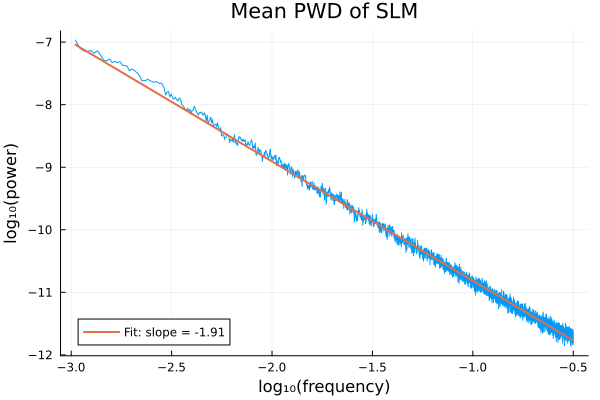

In [15]:
# Take logs
log_k = log10.(frequencies)
log_S = log10.(mean_S)

# Filter logs
mask = (log_k .> -3) .& (log_k .< -0.5)
log_k = log_k[mask]
log_S = log_S[mask]

# Put into a DataFrame and fit linear model: log_S ~ log_k
plot_df = DataFrame(log_k=log_k, log_S=log_S)
model = lm(@formula(log_S ~ log_k), plot_df)

# Extract the slope and intercept
coeffs = coef(model)
slope = coeffs[2]
intercept = coeffs[1]

println("Estimated slope: ", slope)
println("Intercept: ", intercept)

# Plot results
plot(log_k, log_S, label=:none, xlabel="log₁₀(frequency)", ylabel="log₁₀(power)", legend=:bottomleft,
    title="Mean PWD of SLM")
plot!(log_k, predict(model), label="Fit: slope = $(round(slope, digits=2))", lw=2)

In [62]:
# savefig("./Images/psd_LSM_no_noise_average_norm.png")

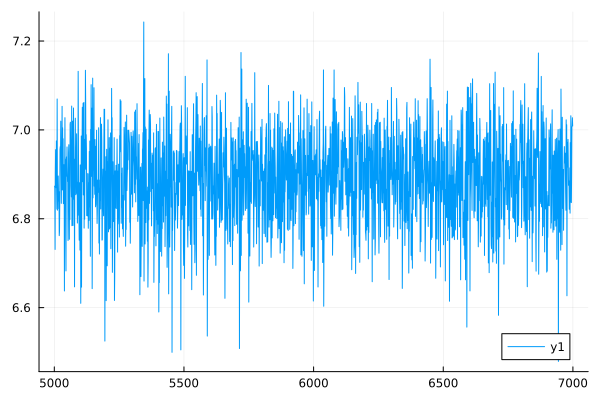

In [64]:
otu = otu_ids[1]
value = df_filtered[df_filtered.variable .== otu, :].value
time = df_filtered[df_filtered.variable .== otu, :].time
plot(time, log.(value))

In [118]:
# savefig("./Images/traj_example_no_noise.png")

"/home/luca/code/lawsdiv/Images/traj_example_no_noise.png"